In [2]:
import os, sys

# notebooks/ klasöründeyiz → bir üstü proje root
PROJECT_ROOT = os.path.abspath("..")

if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

print("PROJECT_ROOT:", PROJECT_ROOT)
print("SRC exists:", os.path.exists(os.path.join(PROJECT_ROOT, "src")))
print("sys.path[0]:", sys.path[0])



PROJECT_ROOT: c:\Users\Casper\Desktop\RLveZS
SRC exists: True
sys.path[0]: c:\Users\Casper\Desktop\RLveZS


In [3]:
from src.env_rl import ProductionLineEnv
from src.lstm_torch import LSTMPredictor

print("Imports OK")



Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


Imports OK


In [11]:
import pandas as pd
import pickle
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env

from src.env_rl import ProductionLineEnv
from src.lstm_torch import LSTMPredictor

df = pd.read_csv("../data/simulated/line_data.csv")

with open("../models/lstm_scaler.pkl", "rb") as f:
    scaler = pickle.load(f)

lstm = LSTMPredictor("../models/lstm_lead_time.pt")

def lstm_predict_fn(window):
    w = window.reshape(-1, 1)
    w = scaler.transform(w)
    return lstm.predict(w)

env = make_vec_env(lambda: ProductionLineEnv(df, lstm_predict_fn), n_envs=1)

model = PPO(
    "MlpPolicy",
    env,
    verbose=1,
    n_steps=512,
    batch_size=128,
    ent_coef=0.1
)

model.learn(30_000)
model.save("../models/ppo_model.zip")


Using cpu device


c:\Users\Casper\Desktop\RLveZS\rl310\lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.8.0 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


ValueError: LSTM: Expected input to be 2D or 3D, got 4D instead

In [12]:
print(lstm_predict_fn(df.iloc[:10][df.columns[0]].values))


ValueError: LSTM: Expected input to be 2D or 3D, got 4D instead

In [5]:
# ============================================================
# 06_metrics_visualization.ipynb - STEP 1 (FIXED)
# ============================================================

import os, sys, pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from stable_baselines3 import PPO

# ------------------------------------------------------------
# Proje root (notebooks/ altındayız)
# ------------------------------------------------------------
PROJECT_ROOT = os.path.abspath("..")
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

# ------------------------------------------------------------
# Kendi modüllerin
# ------------------------------------------------------------
from src.time_series_models import sarima_forecast
from src.lstm_torch import LSTMPredictor
from src.env_rl import ProductionLineEnv   # PPO test için
# NOT: src.lstm_model / tensorflow KULLANMIYORUZ 

# ------------------------------------------------------------
# Dosya yolları
# ------------------------------------------------------------
DATA_PATH   = os.path.join(PROJECT_ROOT, "data", "simulated", "line_data.csv")
LSTM_PT     = os.path.join(PROJECT_ROOT, "models", "lstm_lead_time.pt")
SCALER_PATH = os.path.join(PROJECT_ROOT, "models", "lstm_scaler.pkl")
PPO_PATH    = os.path.join(PROJECT_ROOT, "models", "ppo_model.zip")

FIG_DIR     = os.path.join(PROJECT_ROOT, "reports", "figures")
os.makedirs(FIG_DIR, exist_ok=True)

print("DATA:", DATA_PATH)
print("LSTM (PyTorch):", LSTM_PT)
print("SCALER:", SCALER_PATH)
print("PPO:", PPO_PATH)
print("FIG_DIR:", FIG_DIR)

# ------------------------------------------------------------
# Veri yükleme
# ------------------------------------------------------------
df = pd.read_csv(DATA_PATH)

with open(SCALER_PATH, "rb") as f:
    scaler = pickle.load(f)

# ------------------------------------------------------------
# PyTorch LSTM Predictor
# ------------------------------------------------------------
def lstm_predict_fn(window):
    
    window = np.asarray(window).reshape(-1, 1)
    window_scaled = scaler.transform(window).flatten()
    return lstm_predictor.predict(window_scaled)




# ------------------------------------------------------------
# PPO modeli
# ------------------------------------------------------------
ppo_model = PPO.load(PPO_PATH)

print("\n Loaded successfully:")
print("df shape:", df.shape)
print("Scaler:", type(scaler))
print("LSTM predictor:", type(lstm_predictor))
print("PPO model:", type(ppo_model))


DATA: c:\Users\Casper\Desktop\RLveZS\data\simulated\line_data.csv
LSTM (PyTorch): c:\Users\Casper\Desktop\RLveZS\models\lstm_lead_time.pt
SCALER: c:\Users\Casper\Desktop\RLveZS\models\lstm_scaler.pkl
PPO: c:\Users\Casper\Desktop\RLveZS\models\ppo_model.zip
FIG_DIR: c:\Users\Casper\Desktop\RLveZS\reports\figures


c:\Users\Casper\Desktop\RLveZS\rl310\lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.8.0 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(



 Loaded successfully:
df shape: (2000, 27)
Scaler: <class 'sklearn.preprocessing._data.MinMaxScaler'>


NameError: name 'lstm_predictor' is not defined

In [ ]:
# ============================================================
# STEP 2 - SARIMA + LSTM (PyTorch) METRİKLERİ
# ============================================================

# ---- SARIMA ----
sarima_preds, sarima_mape, sarima_rmse = sarima_forecast(df)
print("SARIMA -> MAPE:", sarima_mape, " RMSE:", sarima_rmse)

# ---- LSTM (PyTorch) ----
# hedef kolon varsayımı: wip_total
series = df["wip_total"].values.astype(float)

# train/test split (son %20 test)
split = int(len(series) * 0.8)
test_series = series[split:]  # sadece test bölümünü raporlayacağız

WINDOW = 24
lstm_preds = []
lstm_true  = []

# tahminleri sliding window ile üret
for i in range(split + WINDOW, len(series)):
    window = series[i - WINDOW:i]
    pred = lstm_predict_fn(window)
    lstm_preds.append(pred)
    lstm_true.append(series[i])

lstm_preds = np.array(lstm_preds, dtype=float)
lstm_true  = np.array(lstm_true, dtype=float)

# sadece test kısmına denk gelen true/pred zaten testten geliyor
lstm_mape = mean_absolute_percentage_error(lstm_true, lstm_preds)
lstm_rmse = np.sqrt(mean_squared_error(lstm_true, lstm_preds))

print("LSTM(PyTorch) -> MAPE:", lstm_mape, " RMSE:", lstm_rmse)

# ---- performans tablosu ----
performance_df = pd.DataFrame({
    "Model": ["SARIMA", "LSTM(PyTorch)"],
    "MAPE":  [sarima_mape, lstm_mape],
    "RMSE":  [sarima_rmse, lstm_rmse]
})

display(performance_df)


SARIMA -> MAPE: 537114357820896.25  RMSE: 36.36423535143793
LSTM(PyTorch) -> MAPE: 303185869333700.8  RMSE: 120.23297365107464


,Model,MAPE,RMSE
0,SARIMA,5.371144e+14,36.364235
1,LSTM(PyTorch),3.031859e+14,120.232974


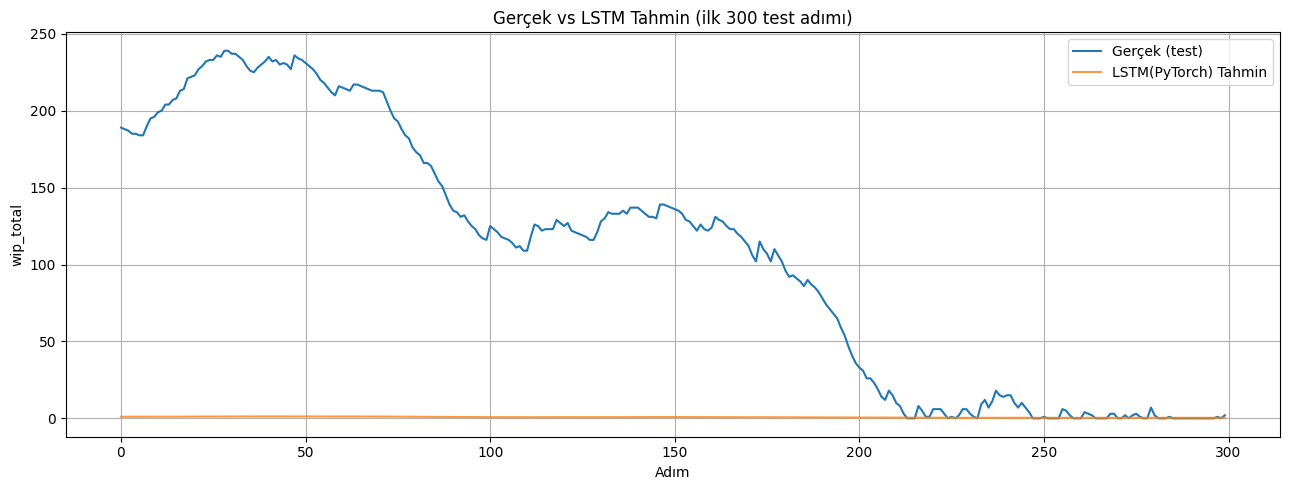

✅ Kaydedildi: c:\Users\Casper\Desktop\RLveZS\reports\figures\lstm_gercek_vs_tahmin.png


In [ ]:
# ============================================================
# STEP 2 - GERÇEK vs TAHMİN GRAFİĞİ
# ============================================================

plt.figure(figsize=(13,5))

# LSTM true/pred (test)
plt.plot(lstm_true[:300], label="Gerçek (test)")
plt.plot(lstm_preds[:300], label="LSTM(PyTorch) Tahmin", alpha=0.8)

plt.title("Gerçek vs LSTM Tahmin (ilk 300 test adımı)")
plt.xlabel("Adım")
plt.ylabel("wip_total")
plt.legend()
plt.grid()
plt.tight_layout()

out_path = os.path.join(FIG_DIR, "lstm_gercek_vs_tahmin.png")
plt.savefig(out_path)
plt.show()

print(" Kaydedildi:", out_path)


In [ ]:
(df["wip_total"] <= 1e-6).sum()


154

In [ ]:
# ============================================================
# PPO TEST RUN (ACTION KAYITLI)
# ============================================================

env_test = ProductionLineEnv(df, lstm_predict_fn)

ppo_rewards = []
ppo_errors  = []
ppo_actions = []   #  YENİ

state, _ = env_test.reset()

for step in range(300):
    action, _ = ppo_model.predict(state, deterministic=True)
    state, reward, done, _, info = env_test.step(action)

    ppo_rewards.append(reward)
    ppo_errors.append(info["abs_err"])
    ppo_actions.append(int(action))   #  KRİTİK

    if done:
        break

print("PPO test steps:", len(ppo_actions))


C:\Users\Casper\AppData\Local\Temp\ipykernel_7560\1504608182.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ppo_actions.append(int(action))   #  KRİTİK
C:\Users\Casper\AppData\Local\Temp\ipykernel_7560\1504608182.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ppo_actions.append(int(action))   #  KRİTİK
C:\Users\Casper\AppData\Local\Temp\ipykernel_7560\1504608182.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ppo_actions.append(int(action))   #  KR

PPO test steps: 300


C:\Users\Casper\AppData\Local\Temp\ipykernel_7560\1504608182.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ppo_actions.append(int(action))   #  KRİTİK
C:\Users\Casper\AppData\Local\Temp\ipykernel_7560\1504608182.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ppo_actions.append(int(action))   #  KRİTİK
C:\Users\Casper\AppData\Local\Temp\ipykernel_7560\1504608182.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ppo_actions.append(int(action))   #  KR

In [ ]:
# ============================================================
# RANDOM POLICY BASELINE
# ============================================================

env_random = ProductionLineEnv(df, lstm_predict_fn)

random_rewards = []
random_errors  = []

state, _ = env_random.reset()

for step in range(300):
    action = env_random.action_space.sample()
    state, reward, done, _, info = env_random.step(action)

    random_rewards.append(reward)
    random_errors.append(info["abs_err"])

    if done:
        break

print("Random test steps:", len(random_rewards))


Random test steps: 300


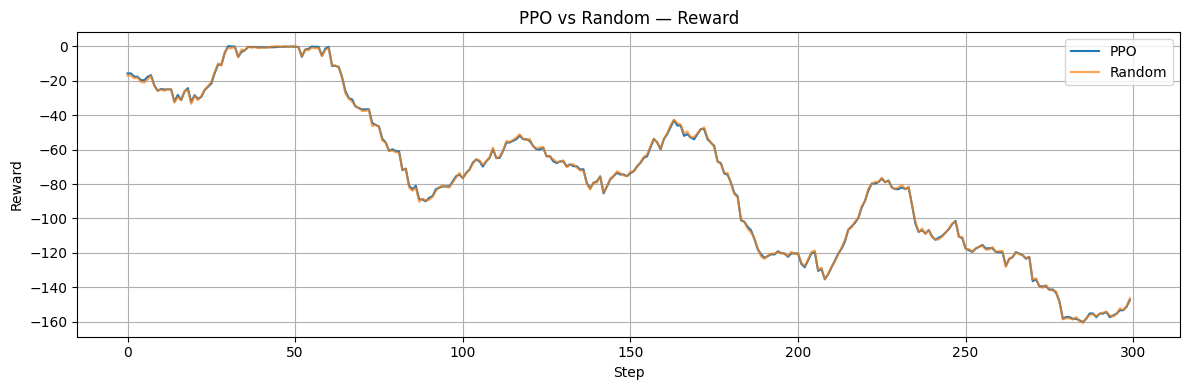

 Kaydedildi: c:\Users\Casper\Desktop\RLveZS\reports\figures\ppo_vs_random_reward.png


In [ ]:
# ============================================================
# PPO vs RANDOM - REWARD
# ============================================================

plt.figure(figsize=(12,4))
plt.plot(ppo_rewards, label="PPO")
plt.plot(random_rewards, label="Random", alpha=0.7)

plt.title("PPO vs Random — Reward")
plt.xlabel("Step")
plt.ylabel("Reward")
plt.legend()
plt.grid()
plt.tight_layout()

out_path = os.path.join(FIG_DIR, "ppo_vs_random_reward.png")
plt.savefig(out_path)
plt.show()

print(" Kaydedildi:", out_path)


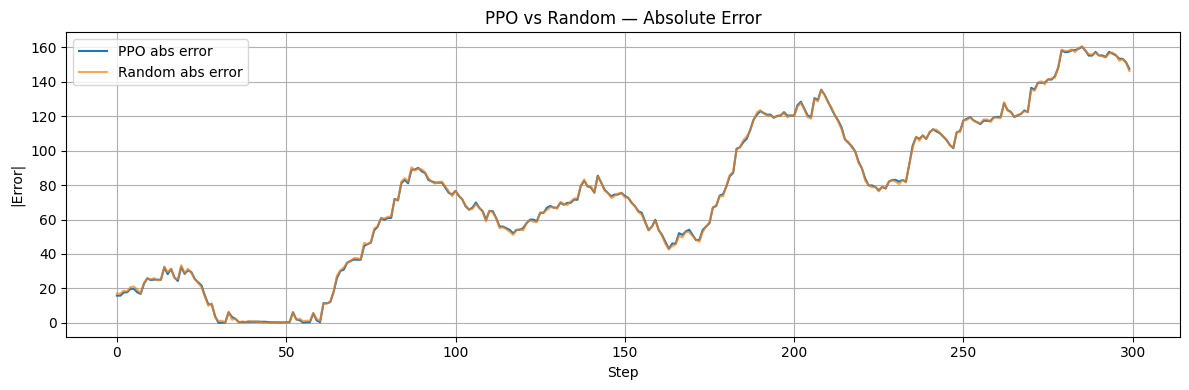

 Kaydedildi: c:\Users\Casper\Desktop\RLveZS\reports\figures\ppo_vs_random_abs_error.png


In [ ]:
# ============================================================
# PPO vs RANDOM — ABS ERROR
# ============================================================

plt.figure(figsize=(12,4))
plt.plot(ppo_errors, label="PPO abs error")
plt.plot(random_errors, label="Random abs error", alpha=0.7)

plt.title("PPO vs Random — Absolute Error")
plt.xlabel("Step")
plt.ylabel("|Error|")
plt.legend()
plt.grid()
plt.tight_layout()

out_path = os.path.join(FIG_DIR, "ppo_vs_random_abs_error.png")
plt.savefig(out_path)
plt.show()

print(" Kaydedildi:", out_path)


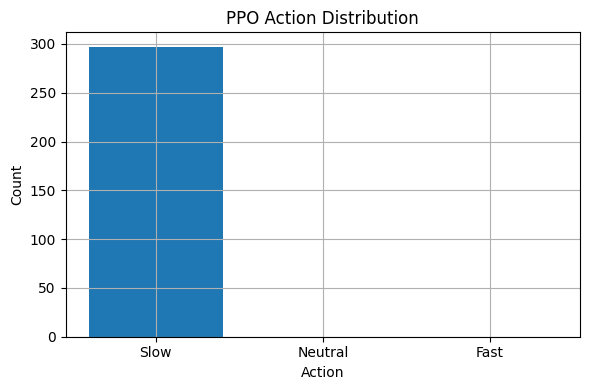

 Kaydedildi: c:\Users\Casper\Desktop\RLveZS\reports\figures\ppo_action_distribution.png


In [ ]:
# ============================================================
# ACTION DISTRIBUTION (PPO)
# ============================================================

plt.figure(figsize=(6,4))
plt.hist(
    ppo_actions,
    bins=[-0.5, 0.5, 1.5, 2.5],
    rwidth=0.8
)

plt.xticks([0, 1, 2], ["Slow", "Neutral", "Fast"])
plt.title("PPO Action Distribution")
plt.xlabel("Action")
plt.ylabel("Count")
plt.grid()
plt.tight_layout()

out_path = os.path.join(FIG_DIR, "ppo_action_distribution.png")
plt.savefig(out_path)
plt.show()

print(" Kaydedildi:", out_path)


In [ ]:
np.unique(ppo_actions, return_counts=True)


(array([-1,  0]), array([  3, 297], dtype=int64))

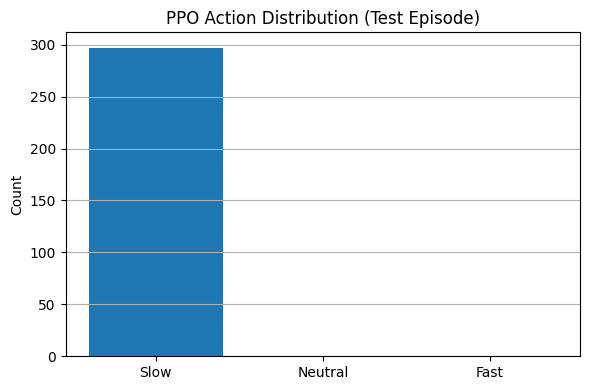

In [ ]:
import collections

counts = collections.Counter(ppo_actions)

labels = ["Slow", "Neutral", "Fast"]
values = [counts.get(0,0), counts.get(1,0), counts.get(2,0)]

plt.figure(figsize=(6,4))
plt.bar(labels, values)
plt.title("PPO Action Distribution (Test Episode)")
plt.ylabel("Count")
plt.grid(axis="y")
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "ppo_action_distribution.png"))
plt.show()


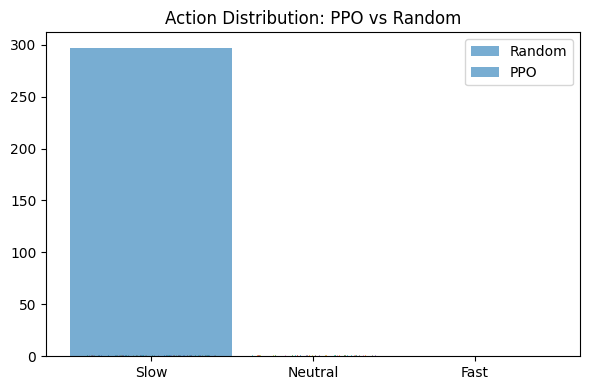

In [ ]:
# Random policy
random_actions = []
env_rand = ProductionLineEnv(df, lstm_predict_fn)
s,_ = env_rand.reset()

for _ in range(300):
    a = env_rand.action_space.sample()
    random_actions.append(a)
    s,_,d,_,_ = env_rand.step(a)
    if d: break

# Karşılaştırma
plt.figure(figsize=(6,4))
plt.hist(random_actions, bins=[-0.5,0.5,1.5,2.5], alpha=0.6, label="Random")
plt.hist(ppo_actions,    bins=[-0.5,0.5,1.5,2.5], alpha=0.6, label="PPO")
plt.xticks([0,1,2], ["Slow","Neutral","Fast"])
plt.legend()
plt.title("Action Distribution: PPO vs Random")
plt.tight_layout()
plt.show()


In [ ]:
ppo_actions = []
ppo_rewards = []

env_test = ProductionLineEnv(df, lstm_predict_fn)
state, _ = env_test.reset()

for _ in range(300):
    action, _ = model.predict(state, deterministic=False)
    ppo_actions.append(action)

    state, reward, done, _, _ = env_test.step(action)
    ppo_rewards.append(reward)

    if done:
        break


In [ ]:
vals, counts = np.unique(ppo_actions, return_counts=True)
dict(zip(vals, counts))


{-1.0: 63,
 -0.9917942: 1,
 -0.98168415: 1,
 -0.9811131: 1,
 -0.9775859: 1,
 -0.9733771: 1,
 -0.95303816: 1,
 -0.9470506: 1,
 -0.9343408: 1,
 -0.93400156: 1,
 -0.9270369: 1,
 -0.9195962: 1,
 -0.91793716: 1,
 -0.89597374: 1,
 -0.89228004: 1,
 -0.88555837: 1,
 -0.8698467: 1,
 -0.867899: 1,
 -0.8661233: 1,
 -0.85467684: 1,
 -0.84817773: 1,
 -0.8408659: 1,
 -0.8353347: 1,
 -0.8219131: 1,
 -0.818565: 1,
 -0.8172803: 1,
 -0.8001899: 1,
 -0.7836883: 1,
 -0.7755546: 1,
 -0.75901145: 1,
 -0.74039173: 1,
 -0.7320361: 1,
 -0.7269874: 1,
 -0.7174676: 1,
 -0.6628816: 1,
 -0.66256255: 1,
 -0.6507784: 1,
 -0.6476959: 1,
 -0.64345545: 1,
 -0.6278682: 1,
 -0.62697655: 1,
 -0.6232704: 1,
 -0.6218312: 1,
 -0.6207299: 1,
 -0.6195545: 1,
 -0.61117923: 1,
 -0.5995133: 1,
 -0.5992703: 1,
 -0.5945528: 1,
 -0.5916793: 1,
 -0.56846666: 1,
 -0.5178092: 1,
 -0.49552852: 1,
 -0.49063632: 1,
 -0.49045894: 1,
 -0.48562673: 1,
 -0.465616: 1,
 -0.46434057: 1,
 -0.45739716: 1,
 -0.4374427: 1,
 -0.41685736: 1,
 -0.37827

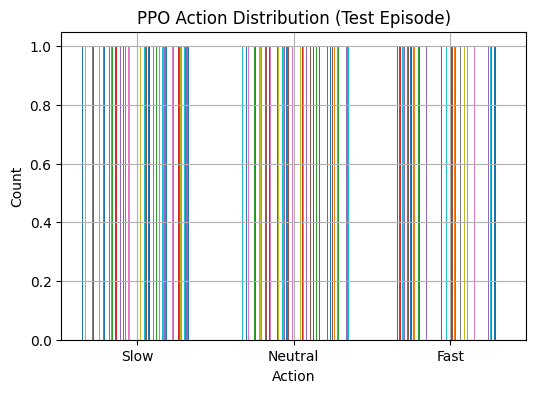

In [ ]:
plt.figure(figsize=(6,4))
plt.hist(ppo_actions, bins=[-1.5,-0.5,0.5,1.5], rwidth=0.7)
plt.xticks([-1,0,1], ["Slow","Neutral","Fast"])
plt.title("PPO Action Distribution (Test Episode)")
plt.xlabel("Action")
plt.ylabel("Count")
plt.grid()
plt.show()


In [ ]:
# RANDOM POLICY
random_rewards = []
env_rand = ProductionLineEnv(df, lstm_predict_fn)
state, _ = env_rand.reset()

for _ in range(len(ppo_rewards)):
    a = env_rand.action_space.sample()
    state, r, done, _, _ = env_rand.step(a)
    random_rewards.append(r)
    if done:
        break


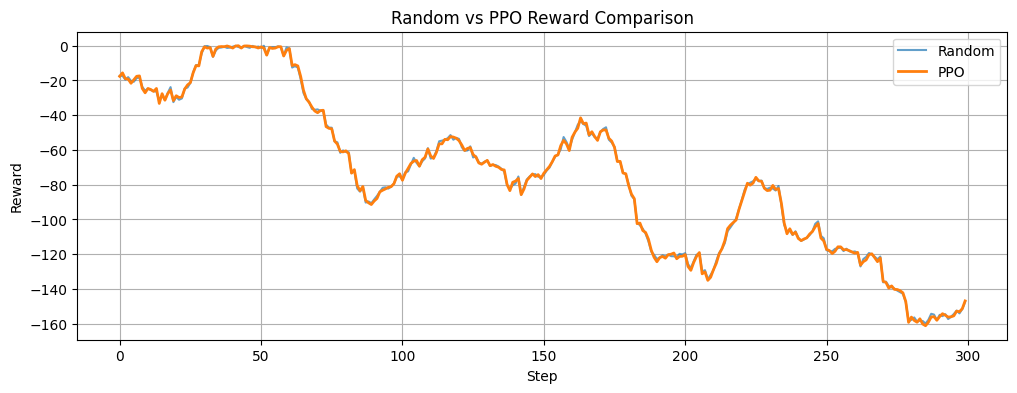

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(random_rewards, label="Random", alpha=0.7)
plt.plot(ppo_rewards, label="PPO", linewidth=2)
plt.title("Random vs PPO Reward Comparison")
plt.xlabel("Step")
plt.ylabel("Reward")
plt.legend()
plt.grid()
plt.show()


In [ ]:
plt.figure(figsize=(12,4))
plt.plot(np.cumsum(random_rewards), label="Random")
plt.plot(np.cumsum(ppo_rewards), label="PPO")
plt.title("Cumulative Reward")
plt.legend()
plt.grid()
plt.show()


NameError: name 'plt' is not defined